# Stock Trading using Actor Critic Model



In [1]:
#imports
import pandas as pd
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt

#for the trading environment
import gym
from gym import error, spaces, utils
from gym.utils import seeding

#for the models
import tensorflow as tf
import tensorflow.keras.layers as kl
import tensorflow.keras.backend as K
import tensorflow.keras.losses as kls

from src.gym_pairs_trading import PairsTradingEnv

In [2]:
print(tf.__version__)

2.0.0


## Data Collection

## Data cleaning

In [3]:
from src.gym_pairs_trading.envs.data_source import DataSource

ds = DataSource("AAPL", "MSFT", size='compact')
df = pd.DataFrame(columns=["Date", "S1 Close", "S2 Close", "S1 Change", "S2 Change"])

for date, data in ds:
    df = df.append({
     "Date": date,
     "S1 Close":  data[0],
     "S2 Close":  data[1],
     "S1 Change":  data[2],
     "S2 Change":  data[3],
      }, ignore_index=True)
    
df.head()
ds.reset()

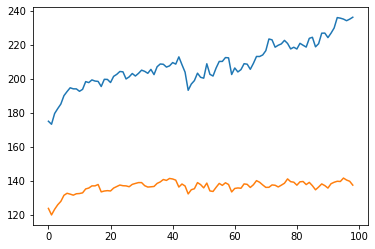

In [4]:
S1_price = df["S1 Close"]
S2_price = df["S2 Close"]
plt.plot(range(0, len(S1_price)), S1_price)
plt.plot(range(0, len(S2_price)), S2_price)

plt.show()

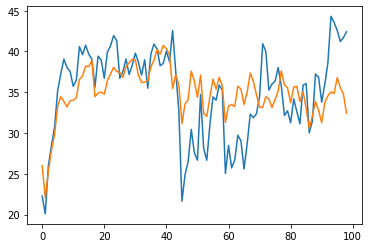

In [5]:
from scipy import signal
s1_detrend = signal.detrend(S1_price) + 35.
s2_detrend = signal.detrend(S2_price) + 35.

plt.plot(range(0, len(S1_price)), s1_detrend)
plt.plot(range(0, len(S2_price)), s2_detrend)

# Set up the environment

## Setting up the Models

In [6]:
from tensorflow.keras.models import Sequential, Model
class ActorCritic(object):
    """ActorCritic model for continous observation space, and discrete action space
    
    Arguments:
        object {[type]} -- [description]
    
    Returns:
        [type] -- [description]
    """
    def __init__(self, env, **kwargs):
        self.env=env

        self.learning_rate = kwargs.get('learning_rate', 0.001)
        self.gamma = kwargs.get('gamma', 0.99)
    
        self.saved_actions = []
        self.saved_values = []
        self.rewards = []
        
        self.actor_model  = self._create_actor_model()
        self.critic_model = self._create_critic_model()

    def _create_actor_model(self):
        model = tf.keras.Sequential([
            kl.Dense(48, activation='relu', input_shape=self.env.observation_space.shape),
            kl.Dense(128, activation='relu'),
            kl.Dense(self.env.action_space.n, activation='softmax', name='policy_logits')
        ])
        model.compile(loss=self._actor_loss(), optimizer='adam')
        return model

    def _create_critic_model(self):
        model = tf.keras.Sequential([
            kl.Dense(48, activation='relu', input_shape=self.env.observation_space.shape),
            kl.Dense(128, activation='relu'),
            kl.Dense(1, activation='relu')
        ])
        model.compile(loss="mse", optimizer='adam')

        return model

    def _actor_loss(self):
        def loss(y_true,y_pred):
            weighted_sparse_ce = kls.SparseCategoricalCrossentropy(from_logits=True)
            actions = tf.cast(y_true[:,1], tf.int32)
            loss = weighted_sparse_ce(actions, y_pred, sample_weight = y_true[:,0])
            return loss
            
        return loss

    def _critic_loss(self):
        def loss(y_true,y_pred):
            return K.mean(K.square(y_pred - y_true), axis=-1)
        
        return loss

    def train(self, obs_history):
        #pv magic number
        advantages = np.array(self.rewards) - np.array(self.saved_values)
        #take negative since we want to minimize LOSS
        #action_loss = -1*advantages*np.array(self.saved_actions)
        y_label = []
        for adv, action in zip(advantages, np.array(self.saved_actions)):
            y_label.append([adv,action,0])
        
        y_label = np.array(y_label)
        self.actor_model.train_on_batch(np.array(obs_history), y_label)
        self.critic_model.train_on_batch(np.array(obs_history), self.rewards)
    
    def eval_state(self, obs):
        return self.critic_model.predict(obs[None, :])
    
    def predict_action(self, obs):
        logits = self.actor_model.predict(obs[None, :])
        action = tf.squeeze(tf.random.categorical(logits, 1), axis=-1)
        return logits[0]
    
    def predict(self,obs):
        return self.eval_state(obs), self.predict_action(obs)
    
    def reset(self):
        self.saved_actions = []
        self.saved_values = []
        self.rewards = []

In [8]:
env = PairsTradingEnv("AAPL","")
model = ActorCritic(env)

-0.05727109570886035
trained


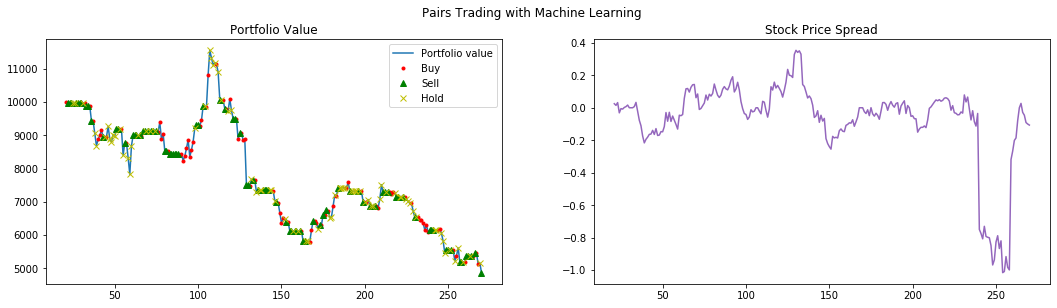

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x12c54d400>
Traceback (most recent call last):
  File "//miniconda3/lib/python3.7/weakref.py", line 358, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt


-0.0556943939703195
trained


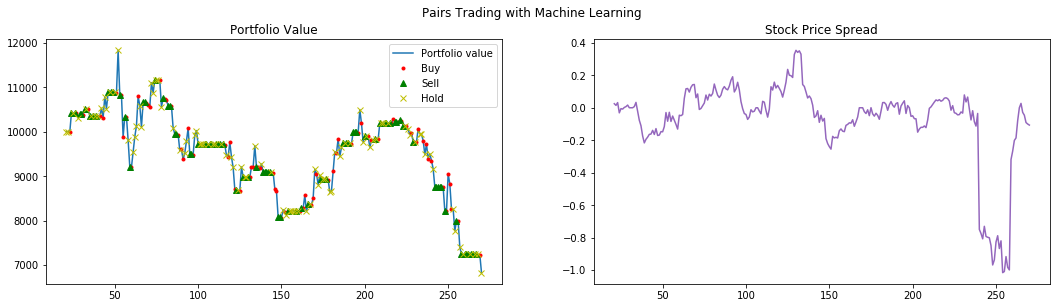

In [ ]:
action_history = []

obs = env.reset()

running_reward = 0
gamma = 0.99
for episode in range(0, 1000):
    obs = env.reset()
    obs_history = []
    model.reset()
    reward = 0
    done = False
    counter = 0
    while not done and counter < 250:
        state_value, actionProb = model.predict(obs)
        action = np.random.choice([0,1,2], p=actionProb)
        obs, reward, done, msg = env.step(action)

        obs_history.append(obs[None, :][0])
        model.saved_actions.append(action)
        model.saved_values.append(state_value[0][0])
        model.rewards.append(reward)
        if done:
            break
        counter+=1
    model.train(obs_history)
    print(reward)
    print("trained")
    env.render()
